# Analysis of light curve periods based precalculated periods

In this notebook I will describe the process for calculating the periods of `LINEAR` light curves and `ZTF` light curves using the *Lomb-Scargle periodogram*. Afterwards, we will save all of the periods and the number of observation points in a `DataFrame` which I will then analyze using descriptive statistics. 

In [25]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm
from astropy.table import Table

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
#from gatspy import periodic
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os
import random

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

In [3]:
import sys
sys.path.insert(0,'../src/')
sys.path
from ZTF_data import *
from descriptive_stats import *
from plotting import *
from config import *
from periods import *

Loading the data!
Loading the data!
Loading the data!


## What is the Lomb-Scargle periodogram?

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the largest strength or the best fit is the real period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

- $ω$ is the frequency we are testing to see if it matches with our light curve.
- $σ^2$ is the variance of the data. We are dividing by it to normalize the data to work across all distributions.
- $∑y_k cosω(t_k−τ)$ and $∑y_k sin ω(t_k−τ)$: checking how well the fitted cosine and sine waves align with the data. $t_k$ is the particular time point, and $τ$ is the time delay, for efficiency.
- $∑cos^2 ω(t_k−τ)$ and $∑ sin^2 ω(t_k−τ)$: normalization of the fitting, in order to eliminate bias towards very strong and/or weak wave components. 

## Why do I use the Lomb-Scargle periodogram?

We use the Lomb-Scargle periodogram because it is the most popular tool used for determining the period of periodic variable stars. It combines multiple methods of analysis, with it's core being in Fourier analysis, and the fact that it operates with non-uniformly spaced data, such is the nature of light curves.

## Example: light curve 10032668

Here, we are going to calculate the period and phase the light curve of star 10032668. 

In [ ]:
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

In [ ]:
# plotting the light curve

t, mag, mager = data.get_light_curve(data.ids[10]).T
fig, ax = plt.subplots()
ax.errorbar(t, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

After looking at the light curve in total, it is time to calculate the period. I use, as mentioned before, the Lomb-Scargle method, and the function is from the `Astropy` library. 

In [ ]:
ls = LombScargle(t, mag, mager) # setting up the Lomb-Scargle object

# calculating the frequency and the power of each frequency for that light curve
frequency, power = ls.autopower(nyquist_factor=350) # here the nyquist factor is pretty high so we don't miss out on a frequency which might be important

# calculating the period
period = 1. / frequency # formula for the period
best_period = period[np.argmax(power)] # choosing the period with the most power
best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power

phase = (t / best_period) % 1 # calculating the phase

In [ ]:
best_period

We see that for this light curve, the period is around 0.61 days. This is quite a short period, most likely a RR Lyrae star.

We can plot the Lomb-Scargle periodogram so we can see the power of each frequency.

In [ ]:
fig, ax = plt.subplots()
ax.plot(frequency, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency',
       ylabel='Power')

We can clearly see that around 0.6 is the most power. Let's plot the phased light curve!

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(phase, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

This looks much better than the previous light curve plot! We can actually see the structure. 

# Calculating `LINEAR` periods

We calculate the periods of `LINEAR` light curves using Astropy's `Lomb-Scargle algorithm`, which uses fourier fitting. Here, we use `nterms=3`, meaning we have 6 Fourier coefficients building our period fit. This gives a much higher level of precision for calculating the periods of single dip light curves, however it is not enough for correct period determination of **eclipsing binaries**. These stars would require `nterms=6`, however this is much too time-consuming and costly to run for 7010 variable stars. The good news is that with `nterms=3`, the period of eclipsing binaries is always twice as less as the correct period, so we can always correct the period later.

In [5]:
# CALCULATING PERIOD OF LINEAR LIGHT CURVES with nyquist=350, nterms=3
#----------------
LINEAR_data = calculating_period('LINEAR', 3, 'LINEAR_test')

Current ID:10003298
Current ID:10004892
Current ID:10013411
Current ID:10021274
Current ID:10022663


Now that we have calculated the periods, we can see the results for the first few light curves.

In [7]:
LINEAR_data

,ID,Frequency,Period,N
0,10003298.0,8.067333,0.123957,196.0
1,10004892.0,1.486845,0.672565,269.0
2,10013411.0,2.800750,0.357047,170.0
3,10021274.0,1.733389,0.576905,214.0
4,10022663.0,1.623512,0.615949,246.0


Now, it's time to select the viable periods from all we have calculated, since quite a few stars don't have enough datapoints to correctly calculate the period.

In [20]:
PeriodsLinear = np.array(LINEAR_data['Period'])
IDs = [x for x in data.ids]

In [21]:
PeriodsLinear

array([0.1239567 , 0.67256506, 0.55531216, ..., 0.34874303, 1.24919353,
       0.65840726])

In [22]:
# ACCESSING THE OFFICIAL PERIODS
#------------
dataPeriods = fetch_LINEAR_geneva() # accessing the good data
PLorig = 10**(dataPeriods['logP'].T) # accessing the periods
ra_orig = dataPeriods['ra'].T # accessing the rectascension
dec_orig = dataPeriods['dec'].T # accessing the declination
ID_orig = list(dataPeriods['LINEARobjectID'].T) # accessing the good ID's

In [24]:
ibad = igood = 0 # current number of good and bad star periods, counters
goodPeriodOrig = [] # list for good original periods
goodPeriodNew = [] # list of good newly calculated periods
goodIDs = [] # list of good ID's from our whole dataset
goodOrigIndex = [] # list of the good  ID


# FINDING 'GOOD' LINEAR PERIODS
#---------------------------------
for id in ID_orig: # for every star in the good dataset 
    if id in IDs:# if the original ID is in our list of ID's
        # this star exists in the "geneva" subsample
        #print(f"id:{id}")
        index = IDs.index(id) # the index is where the id from the good list is in our list
        #print("index:",index)
        goodPeriodOrig.append(PLorig[ID_orig.index(id)]) # append the good period with the correct index
        #print("good period:",goodPeriodOrig)
        goodPeriodNew.append(PeriodsLinear[index]) # append the newly calculated period with the correct index
        #print("my good period:",goodPeriodNew)
        goodIDs.append(id) # append the correct id
        goodOrigIndex.append(ID_orig.index(id)) # append the index of our id
        igood += 1 # count the number of good stars
    else: 
        # not in the "geneva" list 
        ibad += 1 # count the number of bad stars

# PRINT & assign
#-----------------
PeriodOrig = np.array(goodPeriodOrig)
PeriodNew = np.array(goodPeriodNew)
print(igood, ibad)  

5204 942


In [ ]:
# SAVING THE INFORMATION
#---------------------------
# for later perusal in a master file (plus metadata, such as colors)

fout = open('LINEAR_Periods_nterm3.txt', "w") # create a new file in which we can write
fout.write("    LINEAR ID     Porig         Pnew") # write up 3 columns
fout.write("        ra             dec          ug      gi      iK      JK       logP       Ampl    skew    kurt  magMed nObs LCtype \n")    # add the rest of the columns (metadata)
for i in range(0,len(goodIDs)): # for every ID in the new good IDs list
    ID = goodIDs[i] # current ID is the i element in the good list
    Porig = goodPeriodOrig[i] # the original period
    Pnew = goodPeriodNew[i] # the new period
    s = str("%12s " % ID) + str("%12.8f  " % Porig) + str("%12.8f  " % Pnew) # formats values into a string 's', aligning them in columns
    OrigIndex = goodOrigIndex[i] # getting the original index
    LID = dataPeriods[OrigIndex ]['LINEARobjectID'] # accessing the LINEAR ID of that object
    assert ID == LID # asserting that they are the same, so we can continue with the code
    ra = dataPeriods[OrigIndex]['ra'] #accessing the rectascension
    dec = dataPeriods[OrigIndex]['dec'] # accessing the declination
    s = s + str("%12.7f " % ra) + str("%12.7f  " % dec) # formatting previous values into columns
    for q in ['ug','gi','iK','JK']: 
        s = s + str("%7.2f " % dataPeriods[OrigIndex][q]) # loops through the filters and assigns their columns
    s = s + str("%12.8f " % dataPeriods[OrigIndex]['logP']) # adds the logP
    for q in ['Ampl','skew','kurt','magMed']: # loops through the rest of the statistics
        s = s + str("%7.2f " % dataPeriods[OrigIndex][q]) # formats the statistics
    s = s + str("%4.0f " % dataPeriods[OrigIndex]['nObs'])  # adds number of observations
    s = s + str("%2.0f " % dataPeriods[OrigIndex]['LCtype']) # adds light curve type
    s = s + "\n" # next record is in a new line or row
    fout.write(s) # add this string of values as a row
fout.close() # when finished close

# Analysis of `LINEAR` periods

In [62]:
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('../outputs/LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)

In [63]:
L

ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
29848,0.55700898,0.55701916,119.526443,46.96212,1.17,0.37,1.02,0.27,-0.2541378,0.62,-0.31,-0.57,16.37,301,1
32086,0.56925794,0.56926594,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.2446909,0.71,-0.49,-1.0,15.02,289,1
50402,0.64329296,0.6432861,119.712975,52.149574,1.18,0.39,1.1,0.2,-0.1915912,0.49,-0.29,-0.88,16.46,284,1
61011,0.662369,0.66237568,118.491257,53.168125,0.81,0.55,1.62,0.2,-0.1789,0.69,-0.03,-1.06,14.08,274,1
62892,0.53077199,0.53076395,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
91437,0.6747281,0.67471133,120.29496,40.932457,1.18,0.24,1.09,0.37,-0.1708712,0.75,-0.12,-0.93,15.39,177,1
95250,0.31386898,0.31386924,120.124542,40.65662,1.18,-0.14,0.83,0.28,-0.5032516,0.55,0.14,-0.65,16.98,222,2
104455,0.55851803,0.55850723,121.150764,42.483574,1.27,-0.13,1.04,0.74,-0.2529628,0.86,-0.34,-0.13,16.88,119,1
108513,0.47380899,0.47381616,120.915886,42.512482,1.24,-0.05,0.8,0.06,-0.3243967,0.85,-1.17,1.16,16.69,282,1


In [77]:
Properties = []
for i in list(L.columns):
    a = list(L[i])
    Properties.append(a)

In [88]:
j = 0
LINEAR_periods = pd.DataFrame()
for i in list(L.columns):
    LINEAR_periods.insert(j, i, Properties[j])
    j += 1
LINEAR_periods

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,24166005,1.851441,0.925722,166.485321,76.078506,1.29,0.67,1.52,0.46,0.267510,0.38,2.33,6.49,14.68,166,5
5200,24205854,1.424513,0.712261,169.053696,0.297935,1.49,0.86,1.65,0.59,0.153666,0.51,5.82,43.90,16.13,443,5
5201,24209652,1.490753,0.745362,169.572021,-0.245896,1.11,0.38,1.20,0.45,0.173406,0.75,2.56,6.46,15.95,434,5
5202,24215207,0.763200,0.381601,168.818787,12.683557,1.63,0.87,1.69,0.61,-0.117362,0.46,2.54,5.88,14.99,528,4


/Users/Ita/opt/miniconda3/envs/var_stars/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log P', ylabel='log Amplitude'>

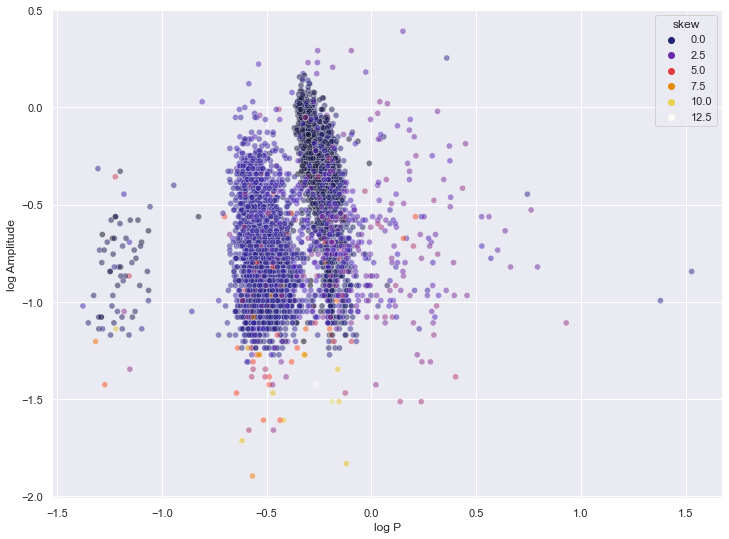

In [96]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlabel('log P')
ax.set_ylabel('log Amplitude')
#------
#data
#------
LINEAR_periods['logAmpl'] = np.log(LINEAR_periods['Ampl'])
#------
sns.scatterplot(LINEAR_periods, x='logP', y='logAmpl', hue='skew', palette='CMRmap',alpha=0.5)

<Axes: xlabel='g-i', ylabel='log P'>

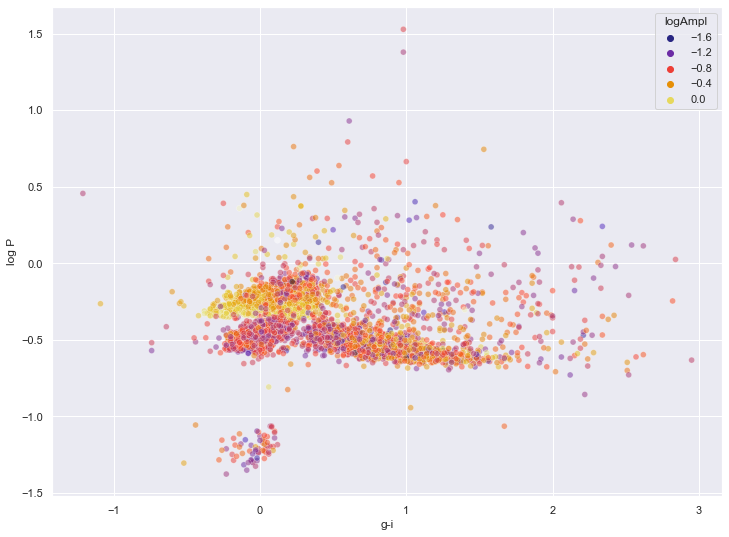

In [98]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlabel('g-i')
ax.set_ylabel('log P')
sns.scatterplot(LINEAR_periods, x='gi', y='logP', hue='logAmpl', palette='CMRmap',alpha=0.5)

# Calculating `ZTF` periods for RR Lyrae

In [106]:
# DIFFERENTIATING THE PERIODS
# dividing the correct period by our period we can differentiate between one dip and eclipsing binaries
Pratio = LINEAR_periods['Porig']/LINEAR_periods['Pnew'] 
print(Pratio)
L1 = LINEAR_periods[(Pratio>0.99)&(Pratio<1.01)]  # one dip
L_EB = LINEAR_periods[(Pratio>1.96)&(Pratio<2.04)]  # eclipsing binaries

0       0.999982
1       0.999986
2       1.000011
3       0.999990
4       1.000015
          ...   
5199    1.999996
5200    1.999988
5201    2.000040
5202    1.999997
5203    2.000011
Length: 5204, dtype: float64


In [107]:
L1.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1,-0.478036
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1,-0.342490
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1,-0.713350
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1,-0.371064
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1,-0.478036


In [108]:
L_EB.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
1958,15617295,0.556593,0.275862,239.874619,2.882987,1.25,0.15,0.97,0.26,-0.254462,0.58,-0.71,-0.39,15.27,45,1,-0.544727
2983,17249,0.252815,0.126407,117.058571,67.081459,1.61,0.94,1.58,0.68,-0.597197,0.57,1.16,0.44,16.16,178,5,-0.562119
2985,41937,0.261539,0.130770,118.729774,49.897243,1.25,0.66,1.36,0.39,-0.582464,0.42,0.40,-0.77,15.84,252,5,-0.867501
2987,51934,0.244835,0.122417,119.304802,52.414425,1.62,0.97,1.78,0.62,-0.611127,0.67,0.65,-0.73,16.30,227,5,-0.400478
2988,56340,0.324801,0.162400,118.446602,52.062500,1.10,0.53,1.02,0.26,-0.488383,0.40,0.73,-0.37,16.22,275,5,-0.916291


In [109]:
# select RR Lyrae using g-i color and previous light curve classification
Lrrlyr = L1[(L1['gi']>-0.5)&(L1['gi']<0.4)&(L1['LCtype']>0)&(L1['LCtype']<3)]
len(Lrrlyr)

2710

In [110]:
Lrrlyr.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1,-0.478036
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1,-0.713350
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1,-0.478036
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1,-0.287682
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2,-0.597837


In [111]:
Lab = Lrrlyr[Lrrlyr['LCtype']==1] # RR Lyrae AB
Lc = Lrrlyr[Lrrlyr['LCtype']==2] # RR Lyrae C
print(len(Lab), len(Lc))

2144 566


In [112]:
Lab.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1,-0.478036
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1,-0.713350
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1,-0.478036
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1,-0.287682
7,104455,0.558518,0.558507,121.150764,42.483574,1.27,-0.13,1.04,0.74,-0.252963,0.86,-0.34,-0.13,16.88,119,1,-0.150823


In [113]:
Lc.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2,-0.597837
10,141414,0.335691,0.335695,120.575195,48.373753,1.30,-0.12,0.95,0.32,-0.474060,0.48,0.29,-1.21,16.25,278,2,-0.733969
14,163933,0.339629,0.339633,121.947922,52.004822,1.25,-0.04,0.79,0.34,-0.468995,0.46,0.11,-1.32,15.53,306,2,-0.776529
16,174389,0.334034,0.334031,121.822433,53.538300,1.26,-0.02,0.70,0.24,-0.476209,0.32,0.14,-0.89,15.05,270,2,-1.139434
19,258499,0.401506,0.401502,123.443306,38.050678,1.19,0.00,0.93,0.28,-0.396308,0.35,-0.08,-0.97,15.43,275,2,-1.049822


In [123]:
L_ids = [x for x in data.ids]
Z_ids = [x for x in range(7010)]

In [125]:
matches = []
for i in range(len(L_ids)):
    m = (L_ids[i], Z_ids[i])
    matches.append(m)
print(matches[:5])

[(10003298, 0), (10004892, 1), (10013411, 2), (10021274, 3), (10022663, 4)]


In [141]:
ZTF_rrlyrae = []

for i in Lrrlyr['ID']:
    for j in matches:
        if i == j[0]:
            m = j
            ZTF_rrlyrae.append(m)

In [143]:
ZTF_rrlyrae[:5]

[(29848, 4898), (50402, 5523), (62892, 5921), (91437, 6749), (95250, 6852)]

In [136]:
LC = pd.DataFrame()

for i in ZTF_rrlyrae:
    if ZTF_data[i[1]][1].shape[0] > 0:
        t, mag, mager = ZTF_data[i[1]][1]['mjd'], ZTF_data[i[1]][1]['mag'],ZTF_data[i[1]][1]['magerr'] # get the data for every light curve
        ls = LombScargle(t, mag, mager, nterms=3) # set up a LombScargle object to model the frequency and power
        frequency, power = ls.autopower(nyquist_factor=350)# calculate the frequency and power

        period = 1. / frequency # calculating the periods
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power
        N = len(t) # number of points used in calculation

        lc_p_ztf = pd.DataFrame([i[1], best_period, N]) # create Dataframe which you will append to main DataFrame
        lc_p_ztf = lc_p_ztf.transpose() # transpose in order to create a row of data
        columns = ['ID ZTF','Period ZTF','N'] # determine columns
        lc_p_ztf.columns = columns # assign columns
        LC = pd.concat([LC, lc_p_ztf], axis=0) # concatenate tables 
        print(f'Current ID:{i[1]}') # print current ID
    else:
        lc_p_ztf = pd.DataFrame([i[1],0,0]) # create Dataframe which you will append to main DataFrame
        lc_p_ztf = lc_p_ztf.transpose() # transpose in order to create a row of data
        columns = ['ID ZTF','Period ZTF','N'] # determine columns
        lc_p_ztf.columns = columns # assign columns
        LC = pd.concat([LC, lc_p_ztf], axis=0) # concatenate tables 
        print(f'Current ID:{i[1]}') # print current ID

Current ID:4898
Current ID:5523


In [144]:
LC.head()

,ID,Period,N
0,4898.0,0.557023,93.0
0,5523.0,0.643312,1535.0


In [187]:
Lrrlyr.head()

,level_0,index,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,logAmpl
0,0,0,29848.0,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301.0,1.0,-0.478036
1,1,2,50402.0,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284.0,1.0,-0.713350
2,2,0,4898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,5523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
